## 🌰 [Day 15](https://adventofcode.com/2018/day/15)

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


def parse_grid(inputs):
  """Parse the inputs into a grid"""
  grid = np.zeros((len(inputs), len(inputs[0])))
  units = []
  for i, line in enumerate(inputs):
    for j, char in enumerate(line):
      if char == '#':
        grid[i, j] = 0
      elif char == '.':
        grid[i, j] = 1
      else:
        elf = char == 'E'
        unit = Unit(i, j, elf)
        units.append(unit)
        grid[i, j] = 2 if elf else 3
  return grid, units


"""Some Pixel sprites for a cool display"""
"""Sources: https://thkaspar.itch.io/micro-character-bases"""
rocky_img = mpimg.imread('day22_rocky.jpg')
narrow_img = mpimg.imread('day22_narrow.jpg')
orc_img = mpimg.imread('day22_orc.png')
orc_img_alpha = (orc_img[:, :, -1] == 1)
orc_img = (orc_img[:, :, :-1]  * 255).astype(np.uint8)
elf_img = mpimg.imread('day22_elf.png')
elf_img_alpha = (elf_img[:, :, -1] == 1)
elf_img = (elf_img[:, :, :-1]  * 255).astype(np.uint8)


def display(grid, units, title=None, figsize=None):
  """Display the grid using some pixel sprites"""
  image = np.zeros((grid.shape[0] * 16, grid.shape[1] * 16, 3), dtype=np.uint8)
  # Plot grid
  x = 0
  for i in range(grid.shape[0]):
    y = 0
    for j in range(grid.shape[1]):
      if grid[i, j] == 0:
        image[x:x + 16, y:y + 16] = rocky_img
      else:
        image[x:x + 16, y:y + 16] = narrow_img
        if grid[i, j] == 2:
          image[x:x + 16, y:y + 16][elf_img_alpha] = 0
          image[x:x + 16, y:y + 16] += elf_img
          image[x + 2, y + 2:y + 14, :] = 255
        elif grid[i, j] == 3:
          image[x:x + 16, y:y + 16][orc_img_alpha] = 0
          image[x:x + 16, y:y + 16] += orc_img
          image[x + 2, y + 2:y + 14, :] = 255
      y += 16
    x += 16
  # Plot units life
  for u in units:
    if u.hp > 0:
      x = 16 * u.x
      y = 16 * u.y
      image[x + 2, y + 2:y + 2 + max(1, int(12 * u.hp / 200))] = (255, 210, 0) if u.elf else (0, 255, 0)
  # Plot
  plt.figure(figsize=figsize if figsize is not None else (12, 12))
  plt.imshow(image)
  if title is not None:
    plt.title(title, fontsize=18)
  plt.axis('off')
  plt.show() 

In [0]:
def init_distances(grid):
  """Init distances as a (w, h, 2) array for Djikstra algorithm. 
  First dimension contain shortest path to current source
  Second dimension contains 1 if the node has yet to be visited, 0 if it has been visited and 
  nan if it is not accessible"""
  max_dist = grid.shape[0] + grid.shape[1]
  distances = np.ones((grid.shape[0], grid.shape[1], 2))
  distances[grid != 1] = np.nan
  distances[:, :, 0] = max_dist
  return distances, max_dist


class Unit:  
  """Defines a unit on the map"""
  
  def __init__(self, x, y, elf):
    """Initialize a unit"""
    self.elf = elf
    self.hp = 200
    self.attack_power = 3
    self.x = x
    self.y = y
    self.target_units = []
    self.in_range = []
    
  def is_in_range(self, unit):
    """Checks if unit is in range of the current unit"""
    return ((self.x == unit.x and self.y == unit.y + 1) or 
            (self.x == unit.x and self.y == unit.y - 1) or
            (self.x == unit.x + 1 and self.y == unit.y) or
            (self.x == unit.x - 1 and self.y == unit.y))
  
  def attempt_attack(self):
    """Attacks first unit (reading order) in range"""
    if len(self.in_range) == 0:
      return False, None
    else:
      target_index = min(range(len(self.in_range)), key=lambda i: (
          self.in_range[i].hp, self.in_range[i].x, self.in_range[i].y))
      target = self.in_range[target_index]
      target.hp -= self.attack_power
      return True, None if target.hp > 0 else target          
    
  def make_your_move(self, grid):
    """Returns the move to take for the unit or None if there is no free target"""
    ## Build all shortest path from curent unit using the Dijkstra algorithm
    distances, max_dist = init_distances(grid)
    distances[self.x, self.y] = (0, 1)
    next_step = np.zeros((grid.shape[0], grid.shape[1], 2), dtype=np.int32) 
    next_step += max(grid.shape[0], grid.shape[1])
    
    while np.nansum(distances[:, :, 1]):
      # Find next node
      nxt = np.nanargmin(distances[:, :, 0] * distances[:, :, 1])
      nxt = np.unravel_index(nxt, distances.shape[:-1])
      distances[nxt[0], nxt[1], 1] = np.nan
      # Update neighbor
      new_dist =  distances[nxt[0], nxt[1], 0] + 1
      for x, y in [(nxt[0] - 1, nxt[1]), (nxt[0] + 1, nxt[1]), 
                   (nxt[0], nxt[1] - 1), (nxt[0], nxt[1] + 1)]:
        # Update the distance
        if grid[x, y] == 1 and distances[x, y, 0] > new_dist: 
          distances[x, y, 0] = new_dist
          # Update the step to take to reach this path (keep the first one i nreading order)
          if (nxt[0], nxt[1]) != (self.x, self.y):
            next_step[x, y] = min(tuple(next_step[x, y]), tuple(next_step[nxt[0], nxt[1]]))
          else: 
            next_step[x, y] = [x, y]
          
    ## Find closest target point in reading order
    targets = np.zeros_like(grid) + np.nan
    for u in self.target_units:
      targets[u.x - 1, u.y] = 1
      targets[u.x + 1, u.y] = 1
      targets[u.x, u.y + 1] = 1
      targets[u.x, u.y - 1] = 1
    targets[grid != 1] = np.nan
    targets[distances[:, :, 0] >= max_dist] = np.nan
    # No reachable target
    if np.nansum(targets) == 0:
      return None
    # Find closest one
    else:
      targets *= distances[:, :, 0]
      targets = (targets == np.nanmin(targets))
      targets = np.argmax(targets) # returns first in reading order
      targets = np.unravel_index(targets, grid.shape)  
      return next_step[targets]    

In [0]:
def play(inputs, 
         num_rounds=-1,
         verbose=False,
         elf_attack_power=3,
         stop_when_hurt_elf=False,
         debug=0,
         figsize=(12, 12)):
  """Play the game
  
  Args:
    inputs: Puzzle input
    num_rounds: Number of rounds. If -1 plays until stopping criterion reached
    verbose: Displays the grid
    elf_attack_power: Set the elves' attack power
    stop_when_hurt_elf: For part II, stop whenever a elf gets hurt
    debug: If > 0, display the grid every `debug` steps
    figsize: Display figure size
  """
  grid, units = parse_grid(inputs)
  
  # Initialise units path search
  for i, u in enumerate(units):
    # Set elves attack power
    if u.elf:
      u.attack_power = elf_attack_power
    # Check in range
    for v in units[i + 1:]:
      if u.elf != v.elf:
        u.target_units.append(v)
        v.target_units.append(u)
        if u.is_in_range(v):
          u.in_range.append(v)
          v.in_range.append(u)   
          
  # Extra verbose (display initial state)
  if verbose > 1:
    display(grid, units, title='Initial State', figsize=figsize)
    
  # Play
  n = 0
  while 1:
    units = sorted(units, key=lambda u: (u.x, u.y))
    
    ## Play units one by one in reading order
    for i, u in enumerate(units):        
      ## If hasn't been killed in that round:
      if u.hp <= 0:
        continue
        
      ## If not in range, tries to move
      if len(u.in_range) == 0:
        move = u.make_your_move(grid)
        if move is not None:
          grid[u.x, u.y] = 1
          u.x = move[0]
          u.y = move[1]
          grid[u.x, u.y] = 2 if u.elf else 3
          for v in u.target_units:
            if u.is_in_range(v) and v.hp > 0:
              u.in_range.append(v)
              v.in_range.append(u)
      
      ## Once moved, or if already in range, attempts attack
      has_attacked, target = u.attempt_attack()
      if has_attacked:
        # Additionally, f target dies, removes it from the grid and from any unit
        if target is not None: 
          # Stop if an elf died
          if stop_when_hurt_elf and target.elf:
            print('\rAttack power %d, elf died at round %d' % (elf_attack_power,  n + 1), end='')
            return None
          grid[target.x, target.y] = 1
          for v in units:
            if target.elf != v.elf:
              v.target_units = [x for x in v.target_units if x != target]
              v.in_range = [x for x in v.in_range if x != target]          
          ## Stop game if no more targets in one team
          if len(set(v.elf for v in units if v.hp > 0)) == 1:
            num_full_rounds = n if (i < len(units) - 1) else n + 1
            hp_sum = sum(max(v.hp, 0) for v in units)
            # Display final state
            if verbose:
              display(grid, units, title='Final state (in round %d)' % (n + 1), figsize=figsize)
            print('Finished game in %d rounds' % num_full_rounds)
            return hp_sum * num_full_rounds
      
    ## End of round cleaning    
    units = [u for u in units if u.hp >= 0]
    if debug > 0 and (n + 1) % debug == 0:
      display(grid, units, title='Round %d' % (n + 1), figsize=figsize)
    n += 1
    if num_rounds > 0 and n >= num_rounds:
      break

## Part 1

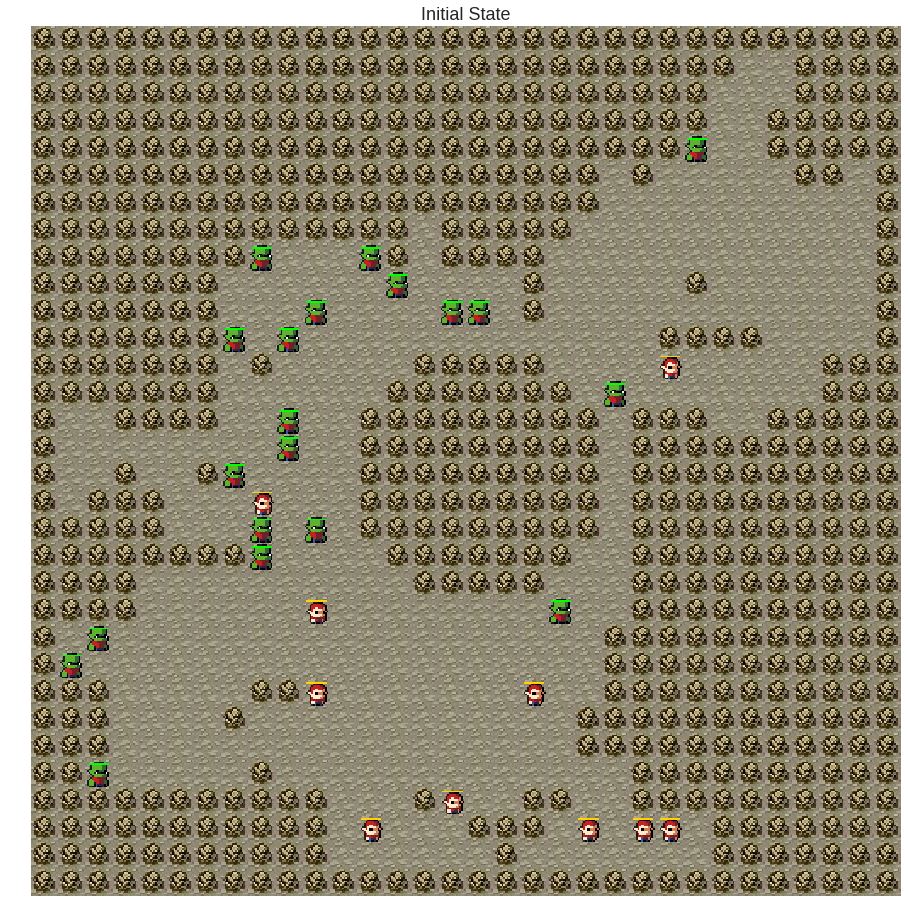

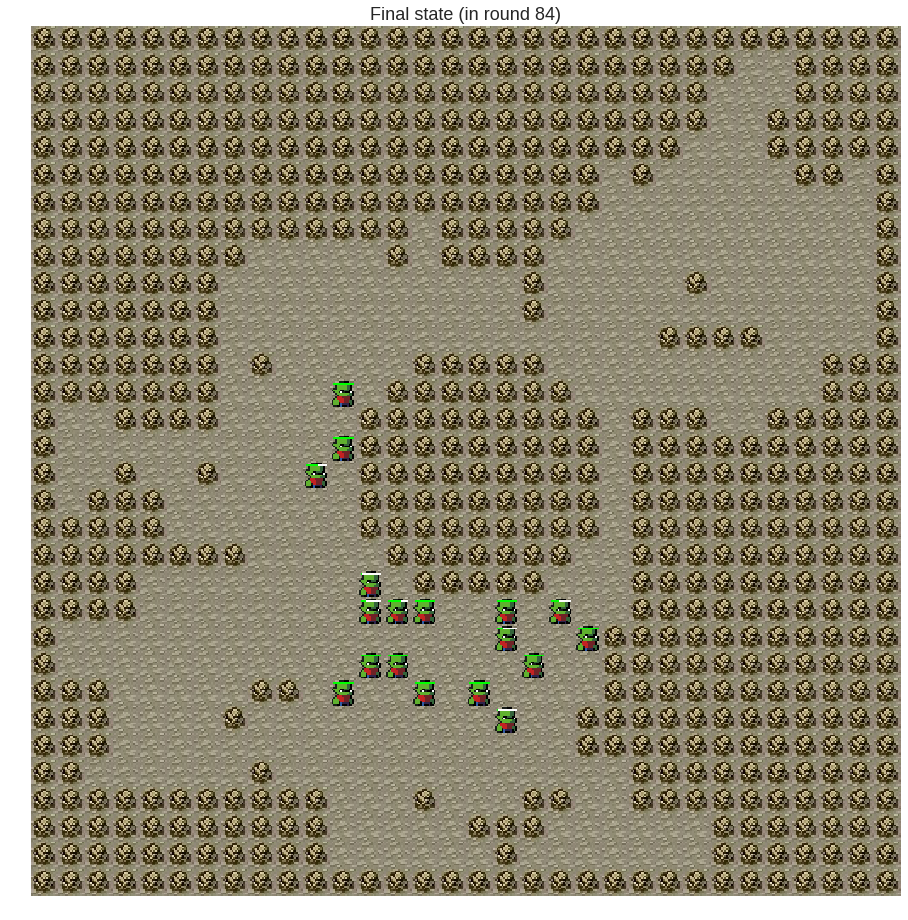

Finished game in 83 rounds
Outcome of the battle: 225096
CPU times: user 24.3 s, sys: 209 ms, total: 24.5 s
Wall time: 25.9 s


In [4]:
%%time
with open('day15.txt', 'r') as f:
  inputs = f.read().splitlines()
  
print("Outcome of the battle:", play(inputs, num_rounds=-1, verbose=2, figsize=(16, 16)))

## Part 2

In [5]:
# For part 2: Do a quick binary search by hand
# 200, 100, 50, 25(x) -> start searching at 25
elf_attack_power = 25
while 1:
  out = play(inputs, num_rounds=-1, verbose=False, elf_attack_power=elf_attack_power, stop_when_hurt_elf=True)
  if out is not None:
    print("Elf attack power %d yields outcome %d" % (elf_attack_power, out))
    break
  elf_attack_power += 1

Attack power 39, elf died at round 20Finished game in 22 rounds
Elf attack power 40 yields outcome 35354
